<a href="https://colab.research.google.com/github/navoday01/ResNet5M-CIFAR10/blob/main/ResnetQuickTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Image Classification Demo on CIFAR10 dataset**
This is a notebook for testing image classification network from [ResNet5M-CIFAR10](https://github.com/navoday01/ResNet5M-CIFAR10)

Different Resnet architecture models and the code of the notebook is available here https://github.com/navoday01/ResNet5M-CIFAR10


**Environment Setup**

Download the pretrained models from GitHub repository

In [ ]:
!git clone https://github.com/navoday01/ResNet5M-CIFAR10.git

fatal: destination path 'ResNet5M-CIFAR10' already exists and is not an empty directory.


**Imports and utility functions**

We need pytorch, and some utilities for visualizing the data.

In [ ]:
# Importing libraries:
!pip install torchinfo
import torch
import torchvision
from torch import nn
from tqdm import tqdm
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
import torchvision.transforms as T
from torchinfo import summary
from torchvision.utils import make_grid
import warnings 
warnings.filterwarnings("ignore")
from PIL import Image
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Load the CIFAR10 test dataset** 


Here we download the test dataset of CIFAR10 from pytorch library. We normalize the images with mean and standard deviation of RGB pixel values of the test  dataset and load the data in dataloader. 

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4913996458053589, 0.48215845227241516, 0.44653093814849854), (0.2470322549343109, 0.24348513782024384, 0.26158788800239563))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
classes = testset.classes
# Images are loaded in batches of 128 images
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

Files already downloaded and verified


**Visualize test Dataset**

We visualize image in one batch of the test dataset

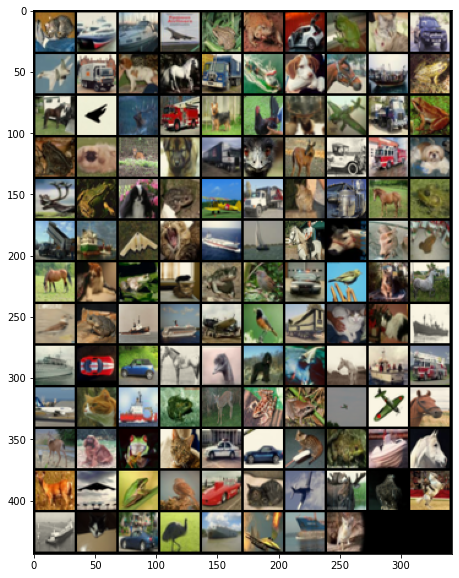

In [ ]:
# We denormalize image for better visualization
data_stats = [(0.4913996458053589, 0.48215845227241516, 0.44653093814849854),(0.2470322549343109, 0.24348513782024384, 0.26158788800239563)]
def denormalize(images,means,stdDev):
    means = torch.tensor(means).reshape(1,3,1,1)
    stdDev = torch.tensor(means).reshape(1,3,1,1)
    return(images*stdDev+means)

def showPreview(dl):

    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(10,10))
        ax.imshow(make_grid(denormalize(images,*data_stats),10).permute(1,2,0))
        break

showPreview(test_loader)

**Loading image classification model**

Here we load a pretrained image classification model.  Like any pytorch model, we can call it like a function, or examine the parameters in all the layers.

After loading, we put it on the GPU, if available.  And since we are doing inference, not training, we put the model in eval mode.

In [ ]:
model = torch.load('/content/ResNet5M-CIFAR10/ResNet.pt')

# Loading model to gpu device if available:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model.to(device)

Using cuda device


RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=BasicBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      (shortcut): RecursiveScriptModule(original_name=Sequential)
    )
    (1): RecursiveScriptModule(
      original_name=BasicBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      (shortcut): RecursiveScriptModule(original_name=Sequential)
    )
  )
  (layer2): Recursi

**Function for testing model with Data Loader**

We define a function to calculate accuracy and a fuction to test the model with data loader. The get_prediction outputs the actaul labels and predicitions made by the model.

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
def get_predictions(model, iterator, device):
    model.eval()
    test_acc = 0
    labels = []
    probs = []
    with torch.no_grad():      
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred= model(x)
            acc = calculate_accuracy(y_pred, y)
            test_acc+=acc.item()
            labels.append(y.to(torch.device('cpu')))
            probs.append(y_pred.to(torch.device('cpu')))
        labels = torch.cat(labels, dim = 0)
        probs = torch.cat(probs, dim = 0)
        print("Test Accuracy:", test_acc/len(iterator))
    return labels, probs

**Test the model here**

Finally we pass the test dataset images to the model

Change the test_loader with different dataloader to test on different test dataset. 

In [ ]:
labels, probs = get_predictions(model, test_loader, device)  
# Pick the class having maximum predicted probabily
pred_labels = torch.argmax(probs, 1)  

Test Accuracy: 0.9450158227848101


**Confusion Matrix**

Confusion matrix is a great way to visualize how model working with different classes. Here we plot a confusion matrix with the predictions made on test dataset.

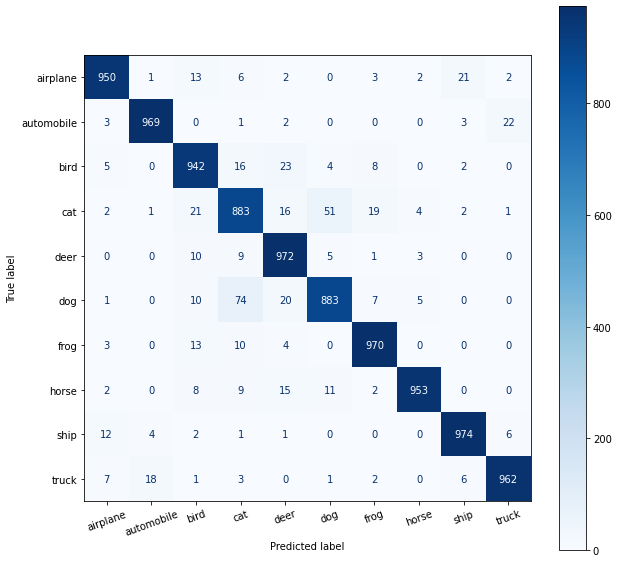

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes): 
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
plot_confusion_matrix(labels, pred_labels, classes)     

**Testing on Random images in test set**

Pick 10 random images from test data and pass through model to find predicted class.

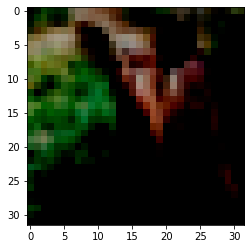

Actual Class:  deer
Predicted Class :  deer


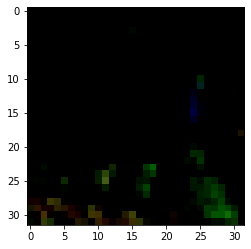

Actual Class:  bird
Predicted Class :  deer


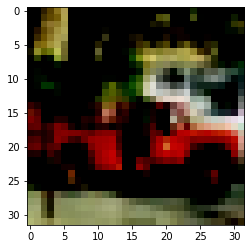

Actual Class:  truck
Predicted Class :  truck


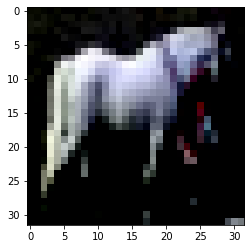

Actual Class:  horse
Predicted Class :  horse


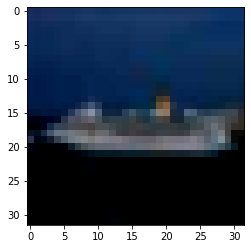

Actual Class:  ship
Predicted Class :  ship


In [ ]:
random_array = np.random.randint(0,10000,size=5)   
for i in random_array:
  img = testset[i][0]
  img_np = img.numpy()  # 3,32,32
  img_np = np.transpose(img_np, (1, 2, 0))
  plt.imshow(img_np)
  plt.show()
  print('Actual Class: ',classes[testset[i][1]])
  img = img.reshape(1, 3, 32, 32)
  with torch.no_grad():
    logits = model(img.to(device))
  y = torch.argmax(logits)
  print("Predicted Class : ", classes[y.item()])         


**Upload Image**

Upload a image you want to test the model.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dog.jpg to dog (2).jpg


**Test the model**

Change the image path and send it throug model to get the prediction

Predicted Class :  dog


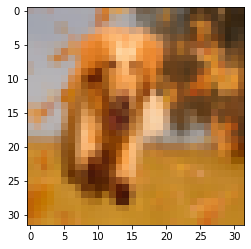

In [ ]:
# Enter the name/path of uploaded image
img = Image.open('dog.jpg')
imageTensorTransform = transforms.ToTensor()
resize = T.Resize((32,32))
smallB = resize(img)
img = imageTensorTransform(smallB)
plt.imshow(smallB)

img = img.reshape(1, 3, 32, 32)
with torch.no_grad():
    logits = model(img.to(device))
y = torch.argmax(logits)
print("Predicted Class : ", classes[y.item()]) 